In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
import zipfile
import urllib.request

url = 'http://ergast.com/downloads/f1db_csv.zip'
filehandle, _ = urllib.request.urlretrieve(url)
zf = zipfile.ZipFile(filehandle, 'r')

results_df = pd.read_csv(zf.open('results.csv'))
drivers_df = pd.read_csv(zf.open('drivers.csv'))
lap_times_df = pd.read_csv(zf.open('lap_times.csv'))
pit_stops_df = pd.read_csv(zf.open('pit_stops.csv'))
races_df = pd.read_csv(zf.open('races.csv'))

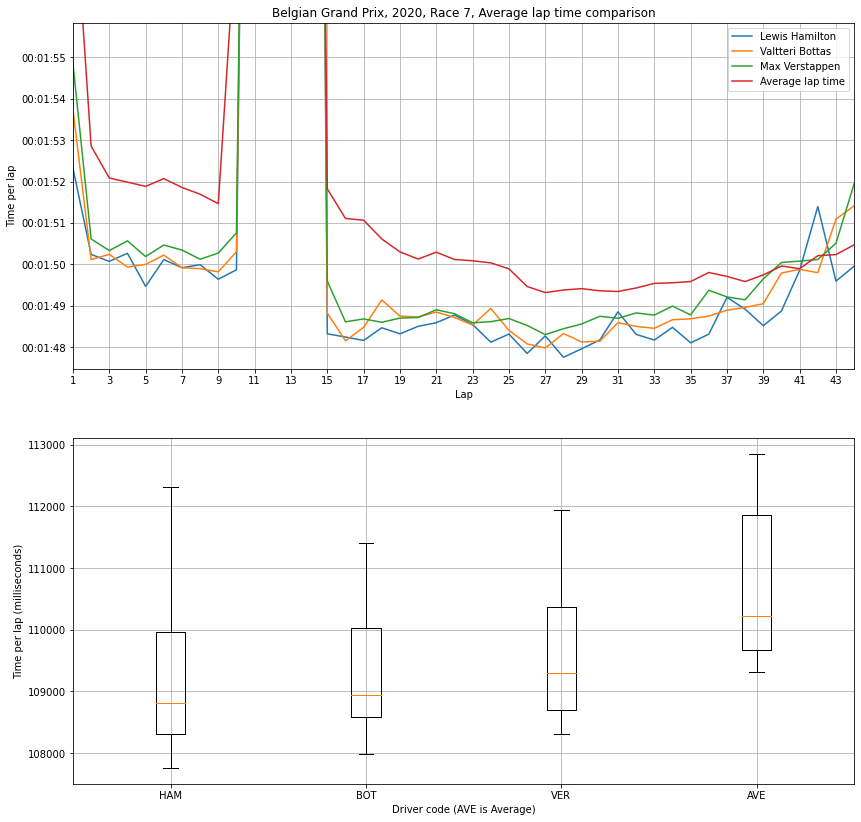

In [2]:
raceId = lap_times_df.raceId.drop_duplicates().iloc[-1]
race_df = lap_times_df[lap_times_df["raceId"] == raceId].copy()
pit_stop_df = pit_stops_df[pit_stops_df.raceId == raceId]
plt.figure(figsize=(14, 14))    
plt.subplot(2, 1, 1)    

for driverId in pit_stop_df.driverId.drop_duplicates():
    for lap in pit_stop_df[pit_stop_df.driverId == driverId].lap:
        race_df.loc[(race_df.driverId == driverId) & (race_df.lap.isin([lap, lap + 1])),'milliseconds'] = np.nan
        mean_value = race_df.loc[(race_df.driverId == driverId) & (race_df.lap.isin([lap - 1, lap + 2]))].milliseconds.mean()
        race_df.loc[(race_df.driverId == driverId) & (race_df.lap.isin([lap, lap + 1])),'milliseconds'] = mean_value
        
for driverId in results_df[results_df.raceId == raceId].driverId.iloc[:3]:
    driver_info = drivers_df[drivers_df["driverId"] == driverId]
    driver_name = driver_info["forename"] + ' ' + driver_info["surname"]
    plt.plot(race_df[race_df.driverId == driverId].lap,
             pd.to_datetime(race_df[race_df.driverId == driverId].milliseconds, unit='ms'),
             label = driver_name.iloc[0])
    
plt.plot(race_df.lap.drop_duplicates(),
         [pd.to_datetime(race_df[race_df.lap == lap].milliseconds.mean(), unit='ms') for lap in race_df.lap.drop_duplicates()],
         label = 'Average lap time')

plt.xticks(np.arange(race_df["lap"].values.min(), race_df["lap"].values.max()+1, 2.0))
locator = mdate.SecondLocator()
plt.gca().yaxis.set_major_locator(locator)
plt.xlim(race_df["lap"].values.min(), race_df["lap"].values.max())
q1 = race_df.milliseconds.quantile(0.25)
q3 = race_df.milliseconds.quantile(0.75)
cons = (q3 - q1) * 1.5
high_lim = q3 + cons
low_lim = q1 - cons
plt.ylim(pd.to_datetime(race_df.milliseconds.min(), unit='ms'),
         pd.to_datetime(high_lim, unit='ms'))
plt.legend()
race_name = races_df[races_df["raceId"] == raceId]["name"].iloc[0]
race_year = races_df[races_df["raceId"] == raceId]["year"].iloc[0]
race_round = races_df[races_df["raceId"] == raceId]["round"].iloc[0]
plt.title(str(race_name) + ', ' + str(race_year) + ', Race ' + str(race_round) + ', Average lap time comparison')
plt.xlabel('Lap')
plt.ylabel('Time per lap')
plt.grid()

plt.subplot(2, 1, 2)

for count, driverId in enumerate(results_df[results_df.raceId == raceId].driverId.iloc[:3]):
    driver_info = drivers_df[drivers_df["driverId"] == driverId]
    plt.boxplot(race_df[race_df.driverId == driverId].milliseconds,
                showfliers=False,
                labels=[driver_info.code.iloc[-1]],
                positions=[count])
    
plt.boxplot([race_df[race_df.lap == lap].milliseconds.mean() for lap in race_df.lap.drop_duplicates()],
            showfliers=False,
            labels=["AVE"],
            positions=[count + 1])

plt.xlabel('Driver code (AVE is Average)')
plt.ylabel('Time per lap (milliseconds)')
plt.grid()
plt.show()